In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.integrate import solve_ivp
from scipy import constants

In [189]:
# Conditions
V0 = 750 # Vmax (V)
f0 = 50000 # RF frequency (Hz)
w0 = 2 * np.pi * f0 # Angular frequency
dgap = 1e-4 # gap length (m)
ddiel = 1e-4 # dielectric thickness (m)
dplate = 0.1 # Plate diameter (m)
As = 0.25 * np.pi * dplate**2 # Plate area (m2)
P = 1 # pressure (atm)
T = 400 # Temperature (K)

In [190]:
# Parameters
epsr = 10 # relative permittivity
eps0 = 8.8541878128e-12 # vacuum permittivity (F/m)
type_EEDF = 1 # 1:Maxwellian EEDF, 2:Druyvesteyn EEDF, 1~2: Generalized EEDF
me = constants.electron_mass # electron mass (kg)
qe = constants.elementary_charge # electron charge (C)
NA = constants.Avogadro # Avogadro number (1/mol)
R = 8.2057366e-5 # gas constant (m3-atm/K/mol)
kb = constants.Boltzmann # Boltzmann constant (J/K)
F = 96485.33289 #Faraday constant (C/mol)

In [191]:
# Properties
Mw_AR = 40/1000 # kg/mo

In [192]:
# Electron Collision Reaction Source Treatment
with open('Ar_xsecs.txt', 'r') as file:
    data = file.read()
    file.close()

In [193]:
# Cross-section area Data Generation
rawD = data.split('\n')
rawD = [x for x in rawD if x != '']

reaction_index = []
for i in range(len(rawD)):
    if rawD[i].startswith('Type'):
        reaction_index.append(i)

R_type = list(range(len(reaction_index)))
R_eqn = list(range(len(reaction_index)))
R_Eloss = list(range(len(reaction_index)))
R_ext = list(range(len(reaction_index)))
R_Elevel = []
R_crossA = []
for i, name in enumerate(reaction_index):
    R_type[i] = rawD[name].split(' ')[1]
    R_eqn[i] = rawD[name+1]
    R_Eloss[i] = float(rawD[name+2].split(' ')[0])
    if R_type[i] == 'EXCITATION':
        R_ext[i] = float(rawD[name+2].split(' ')[2])
    else:
        R_ext[i] = 0
    if i != len(reaction_index) - 1:
        data_range = list(range(reaction_index[i]+5,reaction_index[i+1]-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(np.array(Elevel))
        R_crossA.append(np.array(crossA))
    else:
        data_range = list(range(reaction_index[i]+5,len(rawD)-1))
        Elevel = list(range(len(data_range)))
        crossA = list(range(len(data_range)))
        iteration = 0
        for j in data_range:
            Elevel[iteration] = float(rawD[j].split(' ')[2])
            crossA[iteration] = float(rawD[j].split(' ')[4])
            iteration += 1
        R_Elevel.append(Elevel)
        R_crossA.append(crossA)


In [194]:
# Cross-section area interpolation function
from scipy import interpolate
def create_cross_section_interpolator(Elevel,crossA):
    def non_negative_interp(x):
        return np.maximum(0, interpolate.interp1d(Elevel, crossA, kind='cubic', fill_value='extrapolate')(x))
    return non_negative_interp

R_cross_interpolator = list(range(len(reaction_index)))
for i in range(len(reaction_index)):
    R_cross_interpolator[i] = create_cross_section_interpolator(R_Elevel[i],R_crossA[i])

def calculate_cross_section(interpolator, energy):
    return interpolator(energy)

In [195]:
# upper incomplete gamma function
from scipy import special

def upper_incomplete_gamma(a):
    return special.gamma(a)

# EEDF calculation
def calculate_EEDF(type_EEDF,E,E_mean):
    g = type_EEDF
    beta1 = (upper_incomplete_gamma(5/(2*g)))**(3/2)*(upper_incomplete_gamma(3/(2*g)))**(-5/2)
    beta2 = upper_incomplete_gamma(5/(2*g))*upper_incomplete_gamma(3/(2*g))**(-1)
    return g*beta1*E_mean**(-3/2)*np.exp(-(E*beta2/E_mean)**g)

In [196]:
e_grid = np.arange(0,100,0.01)

In [197]:
# Rate Expression
def Rate_coeff(E_mean):
    R_coeff = list(range(len(R_Elevel)))
    for i in range(len(R_coeff)):
        EEDF = calculate_EEDF(type_EEDF,e_grid, E_mean)
        crossA = calculate_cross_section(R_cross_interpolator[i],e_grid)
        R_coeff[i] = np.sqrt(2 * qe / me) * np.trapz(EEDF * crossA * e_grid,e_grid)*NA
    return R_coeff


In [198]:
# Detailed Balance for de-excitation process
index_excitation = [i for i, name in enumerate(R_type) if name == 'EXCITATION']
for i in index_excitation:
    eloss = R_Eloss[i]
    e = R_Elevel[i] - eloss + 1e-15
    sig = calculate_cross_section(R_cross_interpolator[i],R_Elevel[i])
    R_type.append('DE-EXCITATION')
    R_Elevel.append(e)
    R_crossA.append(1/R_ext[i]*(e+eloss)/e*sig)
    R_Eloss.append(-eloss)
    R_eqn.append(f'(rev){R_eqn[i]}')

iter = list(range(len(reaction_index),len(R_eqn)))

for j in iter:
    R_cross_interpolator.append(create_cross_section_interpolator(R_Elevel[j],R_crossA[j]))

In [199]:
# Gas Phase Reaction
k_gas = []
# Ars + Ars => e + Ar + Ar+
R_type.append('Pooling')
R_eqn.append('Ars+Ars=>e+Ar+Ar1p')
R_Eloss.append(0)
k_gas.append(337340000) # forward rate constant (m3/s/mol)
# Ars + Ars => e + Ar + Ar+
R_type.append('Quenching')
R_eqn.append('Ars+Ar=>Ar+Ar')
R_Eloss.append(0)
k_gas.append(1807) # forward rate constant (m3/mol/s)

In [200]:
def calculate_reaction_rates(R_eqn, k, concentrations):
    reaction_rates = []
    for i, eqn in enumerate(R_eqn):
        # 반응물과 생성물 분리
        reactants, products = eqn.split('=>')
        if 'rev' in reactants:
            reactants = products
        # 반응 속도 계산
        rate = k[i]
        for reactant in reactants.split('+'):
            reactant = reactant.strip()
            if reactant == 'e':
                rate *= concentrations['e']
            elif reactant == 'Ar':
                rate *= concentrations['Ar']
            elif reactant == 'Ars':
                rate *= concentrations['Ars']
            elif reactant == 'Ar1p':
                rate *= concentrations['Ar1p']
        
        reaction_rates.append(rate)
    
    return reaction_rates

In [201]:
# plasma model
def model(t,y):
    n_e, n_Ar, n_Ars, n_Ar1p, en, sigma_s = y

    # electron energy
    E_mean = max(en / n_e, 1e-30)

    # calculate elastic collision energy loss
    R_Eloss[0] = 2*me*NA/Mw_AR*(E_mean - 1.5*T*kb/qe)

    # Component molar concentration
    conc = {
        'e': n_e/NA,
        'Ar': n_Ar/NA,
        'Ars': n_Ars/NA,
        'Ar1p': n_Ar1p/NA
    }
    # reaction rate
    r = calculate_reaction_rates(R_eqn, Rate_coeff(E_mean)+k_gas,conc)

    # Inelastic collision frequency
    nue = 0
    for i in range(5):
        nue += r[i] / (n_e/NA)
    
    # Collisional Power Loss
    Sen = 0
    for i in range(5):
        Sen += -r[i] * R_Eloss[i] * F
    
    #mass balance
    dne_dt = (r[2] + r[3] + r[5])*NA
    dn_Ar_dt = (-r[1] - r[2] + r[4] + r[5] + r[6])*NA
    dn_Ars_dt = (r[1] - r[3] - r[4] - 2*r[5] - r[6])*NA
    dn_Ar1p_dt = (r[2] + r[3] + r[5])*NA

    # electron mobility
    mu_e = qe / (me*nue + 1e-30) 

    # electron temperature
    Te = 2*en/(3*n_e)

    # Electron Current Density on wall
    nue_th = np.sqrt(8*qe*Te/me/np.pi) #electron thermal velocity (m/s)
    ne_bnd = -0.5*n_e*nue_th # electron density wall boundary condition
    nje = qe * ne_bnd # electron current density on wall (A/m2)

    dsig_s_dt = nje * qe

    # calculate the voltage and electric field
    V_applied = -V0 * np.sin(w0 * t)*0.5

    # A = np.array([[eps0*epsr, -eps0],[2*ddiel,dgap]])
    # B = np.array([sigma_s, V_applied])
    # E_diel, E_gap = np.linalg.solve(A, B)
    E_gap = V_applied*0.9/dgap
    # energy gain from electric field
    mflux = -n_e*mu_e*E_gap/2
    Pcap = -qe*mflux*E_gap/2 # Capacitive power deposition

    den_dt = (Pcap + Sen)/qe

    return [dne_dt, dn_Ar_dt, dn_Ars_dt, dn_Ar1p_dt, den_dt, dsig_s_dt]

In [202]:
# initialization
n_e0 = 1e6
n_Ar0 = P/R/T*0.99999999999*NA
n_Ars0 = P/R/T*(1-0.99999999999)*NA
n_Ar1p0 = n_e0
en0 = 5 * n_e0
sigma_s0 = 0


In [203]:
# 시간 그리드
tend= 1e-5
t_span = (0,tend)

# 시뮬레이션 실행
sol = solve_ivp(model, t_span, [n_e0, n_Ar0, n_Ars0, n_Ar1p0, en0, sigma_s0], method='BDF')



In [204]:
sol.t

array([0.00000000e+00, 4.68406314e-14, 9.36812628e-14, 5.62087577e-13,
       1.03049389e-12, 2.98060715e-12, 4.93072041e-12, 6.88083368e-12,
       9.31133687e-12, 1.17418401e-11, 1.41723433e-11, 1.66028465e-11,
       2.07209247e-11, 2.48390029e-11, 2.89570811e-11, 3.54278424e-11,
       4.18986038e-11, 4.83693651e-11, 5.48401264e-11, 6.61427705e-11,
       7.74454145e-11, 8.87480586e-11, 1.11078526e-10, 1.33408993e-10,
       1.55739461e-10, 1.78069928e-10, 2.19434899e-10, 2.60799869e-10,
       3.02164839e-10, 3.70887234e-10, 4.39609628e-10, 5.08332022e-10,
       5.77054417e-10, 7.04711253e-10, 8.32368090e-10, 9.60024927e-10,
       1.21008837e-09, 1.46015181e-09, 1.71021526e-09, 1.96027870e-09,
       2.47061348e-09, 2.98094825e-09, 3.49128303e-09, 4.33282147e-09,
       5.17435992e-09, 6.01589836e-09, 6.85743681e-09, 8.79521989e-09,
       1.07330030e-08, 1.26707860e-08, 1.87168285e-08, 2.06584464e-08,
       2.26000644e-08, 2.45416823e-08, 2.85625354e-08, 3.25833886e-08,
      

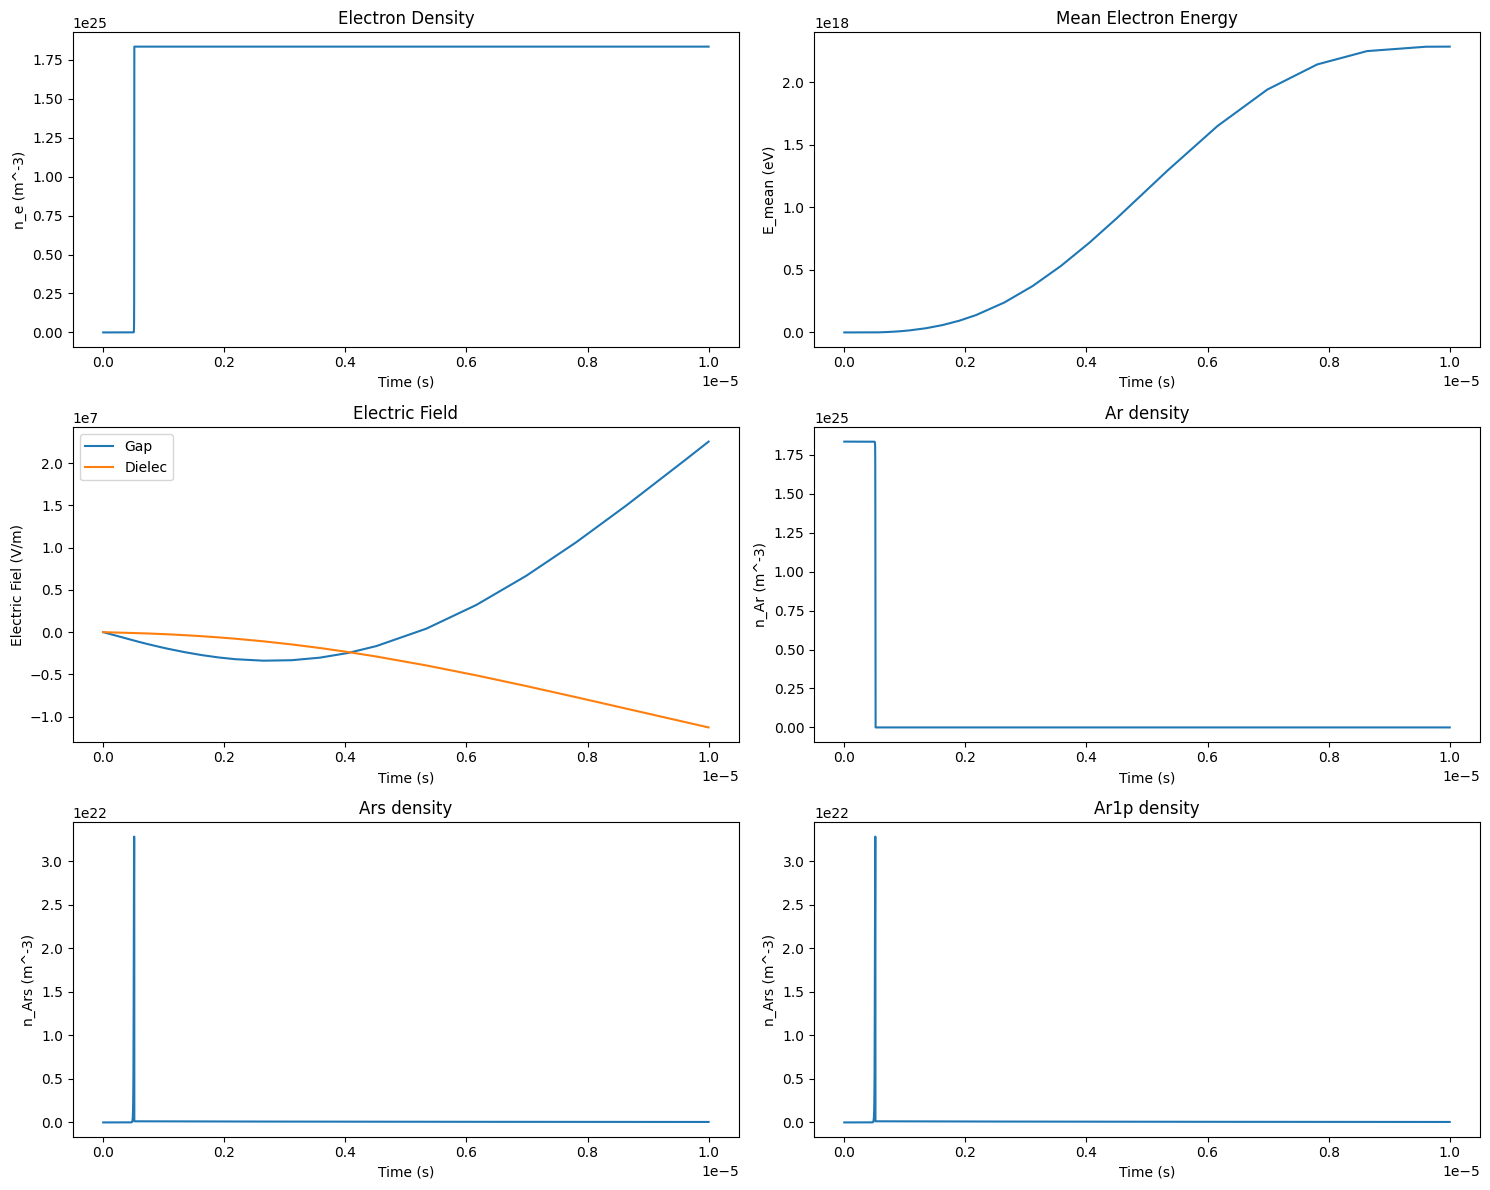

In [205]:
# 결과 플로팅
plt.figure(figsize=(15, 12))

plt.subplot(321)
plt.plot(sol.t, sol.y[0])
plt.title('Electron Density')
plt.xlabel('Time (s)')
plt.ylabel('n_e (m^-3)')

plt.subplot(322)
plt.plot(sol.t, sol.y[4]/sol.y[0])
plt.title('Mean Electron Energy')
plt.xlabel('Time (s)')
plt.ylabel('E_mean (eV)')

plt.subplot(323)
V_applied = -V0 * np.sin(w0 * sol.t)
A = np.array([[eps0*epsr, -eps0],[2*ddiel,dgap]])
B = np.array([sol.y[5], V_applied])
E_diel, E_gap = np.linalg.solve(A, B)
plt.plot(sol.t, E_gap, label='Gap')
plt.plot(sol.t, E_diel, label='Dielec')
plt.title('Electric Field')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Electric Fiel (V/m)')

plt.subplot(324)
plt.plot(sol.t, sol.y[1])
plt.title('Ar density')
plt.xlabel('Time (s)')
plt.ylabel('n_Ar (m^-3)')

plt.subplot(325)
plt.plot(sol.t, sol.y[2])
plt.title('Ars density')
plt.xlabel('Time (s)')
plt.ylabel('n_Ars (m^-3)')

plt.subplot(326)
plt.plot(sol.t, sol.y[2])
plt.title('Ar1p density')
plt.xlabel('Time (s)')
plt.ylabel('n_Ars (m^-3)')


plt.tight_layout()
plt.show()

In [206]:
t = 1e-10
n_e = sol[-1:][0][0]
n_Ar = sol[-1:][0][1]
n_Ars = sol[-1:][0][2]
n_Ar1p = sol[-1:][0][3]
E_mean = sol[-1:][0][4]
sigma_s = sol[-1:][0][5]

# calculate elastic collision energy loss
R_Eloss[0] = 2*me*NA/Mw_AR*(E_mean - 1.5*T*kb/qe)

# electron energy
en = n_e * E_mean

# Component molar concentration
conc = {
    'e': n_e/NA,
    'Ar': n_Ar/NA,
    'Ars': n_Ars/NA,
    'Ar1p': n_Ar1p/NA
}
# reaction rate
r = calculate_reaction_rates(R_eqn, Rate_coeff(E_mean)+k_gas,conc)

# Inelastic collision frequency
nue = 0
for i in range(5):
    nue += r[i] / (n_e/NA)

# Collisional Power Loss
Sen = 0
for i in range(5):
    Sen += -r[i] * R_Eloss[i] * F

#mass balance
dn_e_dt = (r[2] + r[3] + r[5])*NA
dn_Ar_dt = (-r[1] - r[2] + r[4] + r[5] + r[6])*NA
dn_Ars_dt = (r[1] - r[3] - r[4] - 2*r[5] - r[6])*NA
dn_Ar1p_dt = (r[2] + r[3] + r[5])*NA

# electron mobility
mu_e = qe / (me*nue)    

# electron temperature
Te = 2*en/(3*n_e)

# Electron Current Density on wall
nue_th = np.sqrt(8*qe*Te/me/np.pi) #electron thermal velocity (m/s)
ne_bnd = -0.5*n_e*nue_th # electron density wall boundary condition
nje = qe * ne_bnd # electron current density on wall (A/m2)

dsig_s_dt = nje / As

# calculate the voltage and electric field
V_applied = V0 * np.cos(w0 * t)

A = np.array([[eps0*epsr, -eps0],[2*ddiel,dgap]])
B = np.array([sigma_s, V_applied])
E_diel, E_gap = np.linalg.solve(A, B)

# energy gain from electric field
mflux = -n_e*mu_e*E_gap
Pcap = -qe*mflux*E_gap # Capacitive power deposition

den_dt = Pcap + Sen
# energy balance
dE_mean_dt = den_dt/n_e/qe

print(f'ne:{np.format_float_scientific(n_e, precision=3)}')
print(f'E_gap:{np.format_float_scientific(E_gap, precision=3)}')
print(f'E_diel:{np.format_float_scientific(E_diel, precision=3)}')
print(f'E_mean:{np.format_float_scientific(E_mean, precision=3)}')
print(f'mu_e:{np.format_float_scientific(mu_e, precision=3)}')
print(f'Te:{np.format_float_scientific(Te, precision=3)}')
print(f'Sen:{np.format_float_scientific(Sen, precision=3)}')
print(f'Pcap:{np.format_float_scientific(Pcap, precision=3)}')
print(f'r1:{np.format_float_scientific(r[0], precision=3)}')
print(f'r2:{np.format_float_scientific(r[1], precision=3)}')
print(f'r3:{np.format_float_scientific(r[2], precision=3)}')
print(f'r4:{np.format_float_scientific(r[3], precision=3)}')
print(f'r5:{np.format_float_scientific(r[4], precision=3)}')

KeyError: slice(-1, None, None)

In [ ]:
dt = 5e-7
E_mean0 = 5
# calculate elastic collision energy loss
R_Eloss[0] = 2*me*NA/Mw_AR*(E_mean0 - 1.5*T*kb/qe)

# Component molar concentration
conc = {
    'e': n_e0/NA,
    'Ar': n_Ar0/NA,
    'Ars': n_Ars0/NA,
    'Ar1p': n_Ar1p0/NA
}

# reaction rate
r = calculate_reaction_rates(R_eqn, Rate_coeff(E_mean0)+k_gas,conc)

# Inelastic collision frequency
nue = 0
for i in range(5):
    nue += r[i] / (n_e0/NA)

# Collisional Power Loss
Sen = 0
for i in range(5):
    Sen += -r[i] * R_Eloss[i] * F

#mass balance
dn_e_dt = (r[2] + r[3] + r[5])*NA
dn_Ar_dt = (-r[1] - r[2] + r[4] + r[5] + r[6])*NA
dn_Ars_dt = (r[1] - r[3] - r[4] - 2*r[5] - r[6])*NA
dn_Ar1p_dt = (r[2] + r[3] + r[5])*NA

# electron mobility
mu_e = qe / (me*nue)

# electron temperature
Te = 2*en/(3*n_e0)

# Electron Current Density on wall
nue_th = np.sqrt(8*qe*Te/me/np.pi) #electron thermal velocity (m/s)
ne_bnd = 0.5*n_e0*nue_th # electron density wall boundary condition
nje = qe * ne_bnd # electron current density on wall (A/m2)

dsig_s_dt = nje*As

# calculate the voltage and electric field
V_applied = 750

A = np.array([[eps0*epsr, -eps0],[2*ddiel,dgap]])
B = np.array([sigma_s0, V_applied])
E_diel, E_gap = np.linalg.solve(A, B)

# energy gain from electric field
mflux = -n_e0*mu_e*E_gap
Pcap = -qe*mflux*E_gap

den_dt = Pcap + Sen
# energy balance
dE_mean_dt = den_dt/qe/n_e0
print(np.format_float_scientific(r[6], precision=3))



In [ ]:
# electron energy
en = n_e0 * E_mean0






